In [230]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

In [231]:
def load_data():
    # Load the MPG dataset from the local file 'auto-mpg.data'
    # Specify column names to match dataset structure
    columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 
               'weight', 'acceleration', 'model_year', 'origin', 'car_name']
    
    # Load the data using pandas, handling missing values represented by '?'
    data = pd.read_fwf('./a1_code/auto-mpg.data', 
                       names=columns, na_values='?')
    
    # Remove rows with missing values to prepare clean dataset
    data = data.dropna()
    
    # Extract target values (mpg) and input variables (remaining columns except car_name)
    t = data['mpg'].values  # Target variable (miles per gallon)
    X = data[['cylinders', 'displacement', 'horsepower', 
               'weight', 'acceleration', 'model_year', 'origin']].values  # Input features

    # Load the permutation 'rp' from the .mat file to apply randomization
    rp_data = scipy.io.loadmat('./a1_code/rp.mat')
    rp = rp_data['rp'].flatten() - 1  # Flatten the array to 1D and adjust indexing to zero-based

    # Apply the permutation to randomize rows, aligning with shuffled dataset
    X = X[rp, :]
    y = t[rp]

    return y, X  # Return target and features


In [232]:
# Load the processed dataset
y, X = load_data()

# Normalize feature matrix (X) by subtracting mean and dividing by standard deviation
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

# Normalize target vector (y) in a similar way
y_norm = (y - y.mean(axis=0)) / y.std(axis=0)

In [233]:
# Split the normalized data into training and testing sets
X_train, X_test = X_norm[:100], X_norm[100:]  # First 100 samples for training, rest for testing
y_train, y_test = y_norm[:100], y_norm[100:]

In [234]:
# Initialize lists to store root mean squared error (RMSE) values for each polynomial degree
train_errors = []
test_errors = []

# Fit polynomial regression models for degrees 1 through 10
for degree in range(1, 11):
    # Create polynomial features up to the specified degree for the training and testing data
    X_train_poly = np.hstack([X_train**deg for deg in range(degree + 1)])  # Stack features horizontally
    X_test_poly = np.hstack([X_test**deg for deg in range(degree + 1)])

    # Compute regression coefficients using least squares
    coefficients = np.linalg.lstsq(X_train_poly, y_train, rcond=None)[0]

    # Predict target values for training and testing data using the model
    y_train_pred = X_train_poly @ coefficients
    y_test_pred = X_test_poly @ coefficients

    # Calculate RMSE for training and testing predictions
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    
    # Append the errors to track them over different polynomial degrees
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

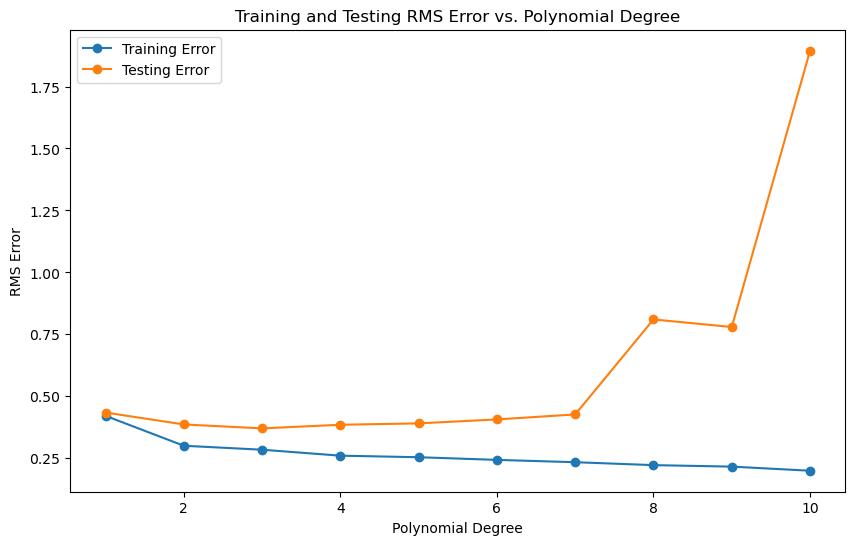

In [235]:
# Plot the training and testing errors versus polynomial degree
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), train_errors, label='Training Error', marker='o')
plt.plot(range(1, 11), test_errors, label='Testing Error', marker='o')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Polynomial Degree')
plt.legend()
plt.show()

# part 2

In [236]:
# Selecting only the third feature (index 2 since Python uses zero-based indexing)
X_single_feature = X_norm[:, 2].reshape(-1, 1)  # Using only the "horsepower" feature here
X_train_single, X_test_single = X_single_feature[:100], X_single_feature[100:]
y_train, y_test = y_norm[:100], y_norm[100:]

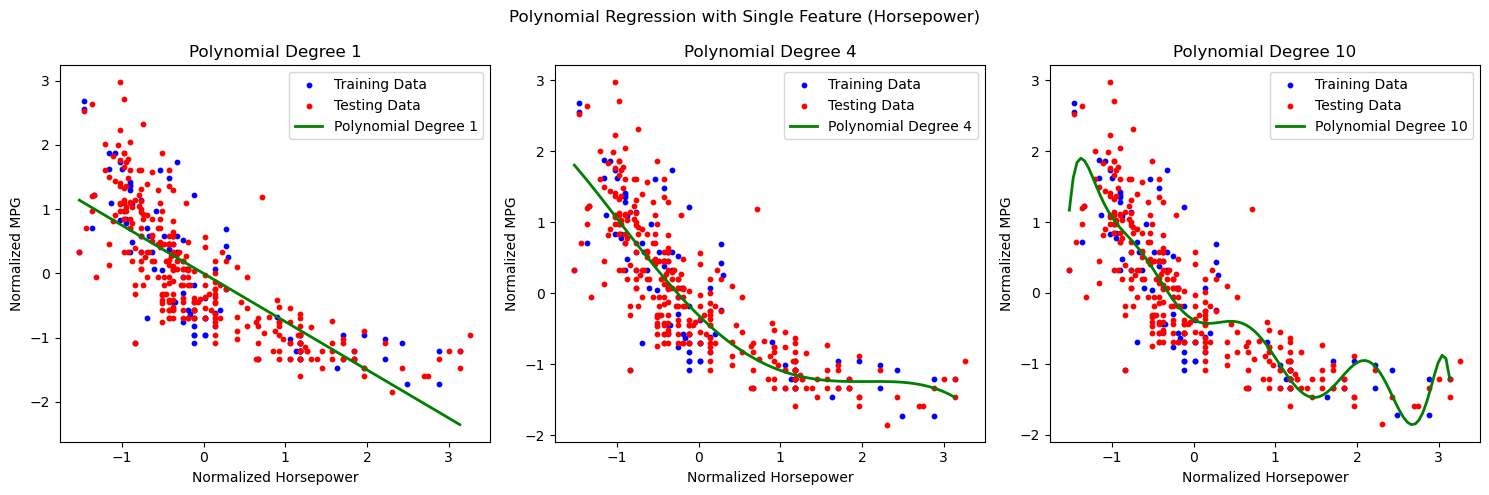

In [237]:
# List of polynomial degrees to visualize the polynomial regression fit for various complexities
degrees_to_plot = [1, 4, 10]  # Choosing low, medium, and high degrees for comparison

# Set up the plotting area with a horizontal layout for each polynomial degree
plt.figure(figsize=(15, 5))

# Loop through each specified polynomial degree for visualization
for plot_index, degree in enumerate(degrees_to_plot):
    # Generate polynomial features up to the current degree for training and testing data
    X_train_poly = np.hstack([X_train_single**deg for deg in range(degree + 1)])
    X_test_poly = np.hstack([X_test_single**deg for deg in range(degree + 1)])
    
    # Calculate regression coefficients using least squares
    coefficients = np.linalg.lstsq(X_train_poly, y_train, rcond=None)[0]
    
    # Generate predictions for training and testing data
    y_train_predictions = X_train_poly @ coefficients
    y_test_predictions = X_test_poly @ coefficients

    # Plot the original data points and the polynomial curve
    plt.subplot(1, len(degrees_to_plot), plot_index + 1)
    plt.scatter(X_train_single, y_train, color='blue', label='Training Data', s=10)
    plt.scatter(X_test_single, y_test, color='red', label='Testing Data', s=10)
    
    # Generate a smooth curve for polynomial fit by using a dense range of x values
    X_range = np.linspace(X_train_single.min(), X_train_single.max(), 100).reshape(-1, 1)
    X_range_poly = np.hstack([X_range**deg for deg in range(degree + 1)])
    
    # Predict y values for the smooth curve
    y_range_predictions = X_range_poly @ coefficients
    
    # Plot the polynomial regression line
    plt.plot(X_range, y_range_predictions, color='green', label=f'Polynomial Degree {degree}', linewidth=2)

    # Add titles, labels, and legend to each subplot
    plt.title(f'Polynomial Degree {degree}')
    plt.xlabel('Normalized Horsepower')
    plt.ylabel('Normalized MPG')
    plt.legend()

# Set a main title and adjust layout for the entire figure
plt.suptitle('Polynomial Regression with Single Feature (Horsepower)')
plt.tight_layout()
plt.show()


# Part 3

In [238]:
# Selecting only the third feature (normalized horsepower)
X_single_feature = X_norm[:, 2].reshape(-1, 1)
X_train_single, X_test_single = X_single_feature[:100], X_single_feature[100:]
y_train, y_test = y_norm[:100], y_norm[100:]

In [239]:
# Function to fit polynomial regression with L2 regularization
def fit_polynomial_l2(X, y, degree, lambda_value):
    # Generate polynomial features up to the specified degree
    X_poly = np.hstack([X**deg for deg in range(degree + 1)])

    # Apply L2 regularization in the normal equation: (X^T X + λI)θ = X^T y
    I = np.eye(X_poly.shape[1])  # Identity matrix for regularization
    I[0, 0] = 0  # Do not regularize the bias term

    theta = np.linalg.solve(X_poly.T @ X_poly + lambda_value * I, X_poly.T @ y)
    
    return theta, X_poly

In [240]:
# Set polynomial degree and regularization values
degree = 8
lambdas = [0, 0.01, 0.1, 1, 10, 100, 1000]  # Regularization parameters

# Lists to store training and testing errors for each lambda
train_errors = []
test_errors = []

# Loop over each regularization value
for lambda_value in lambdas:
    # Fit model on training data
    theta, X_train_poly = fit_polynomial_l2(X_train_single, y_train, degree, lambda_value)

    # Predict on training and testing sets
    y_train_pred = X_train_poly @ theta
    
    X_test_poly = np.hstack([X_test_single**deg for deg in range(degree + 1)])
    y_test_pred = X_test_poly @ theta

    # Calculate RMSE for both training and testing sets
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    
    # Append errors to lists
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

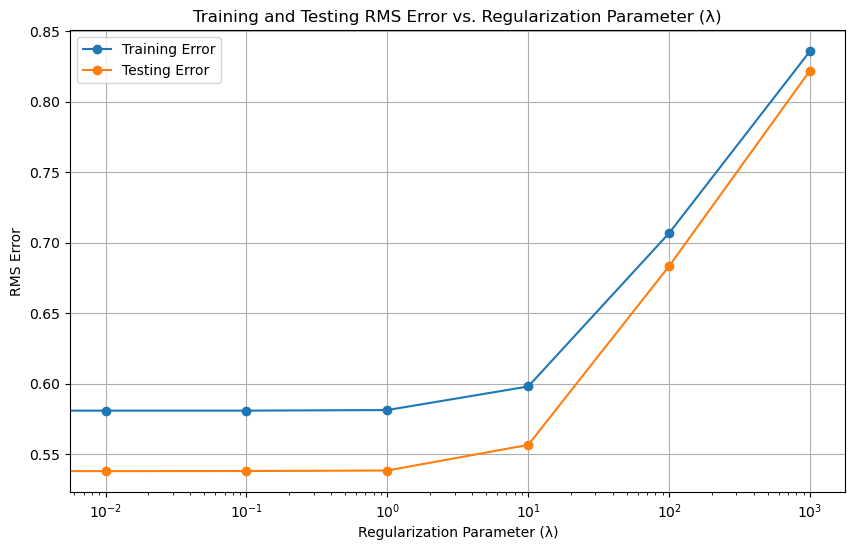

In [241]:
# Plotting training and testing errors vs. regularizer values on a semilog scale
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, train_errors, label='Training Error', marker='o')
plt.semilogx(lambdas, test_errors, label='Testing Error', marker='o')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Regularization Parameter (λ)')
plt.legend()
plt.grid(True)
plt.show()

# part 4-a

In [242]:
def dist2(x, c):
    """
    Calculates the squared Euclidean distance between two sets of points.
    This function mimics the functionality of the MATLAB dist2.m function.
    
    Parameters:
    x (ndarray): Array of shape (M, N) representing M points in N dimensions.
    c (ndarray): Array of shape (L, N) representing L centers in N dimensions.
    
    Returns:
    ndarray: Matrix of shape (M, L) where the (i, j)-th entry is the
             squared distance between x[i] and c[j].
    """
    ndata, dimx = x.shape
    ncentres, dimc = c.shape
    
    if dimx != dimc:
        raise ValueError("Data dimension does not match dimension of centers.")
    
    # Calculate squared distances
    n2 = (np.ones((ncentres, 1)) * np.sum(x**2, axis=1)).T \
         + np.ones((ndata, 1)) * np.sum(c**2, axis=1) \
         - 2 * (x @ c.T)
    
    # Ensure there are no negative distances due to rounding errors
    n2[n2 < 0] = 0
    
    return n2

def gaussian_basis(X, centers, s):
    """Generate a Gaussian basis matrix for input X with given centers and spread s."""
    D = dist2(X, centers)
    return np.exp(-D / (2 * s**2))

In [243]:
# Gaussian basis parameters
s = 2  # Gaussian spread parameter
basis_sizes = range(5, 100, 10)  # Number of basis functions to try

# Part 1: Gaussian basis function regression with varying numbers of basis functions (no regularization)
train_errors = []
test_errors = []

for M in basis_sizes:
    # Randomly select M training points as the centers for the Gaussian basis functions
    random_indices = np.random.permutation(X_train.shape[0])[:M]
    centers = X_train[random_indices]

    # Compute Gaussian basis matrices for training and testing data
    Phi_train = gaussian_basis(X_train, centers, s)
    Phi_test = gaussian_basis(X_test, centers, s)

    # Fit linear regression model with no regularization
    theta = np.linalg.pinv(Phi_train) @ y_train

    # Make predictions
    y_train_pred = Phi_train @ theta
    y_test_pred = Phi_test @ theta

    # Calculate RMSE for both training and testing data
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

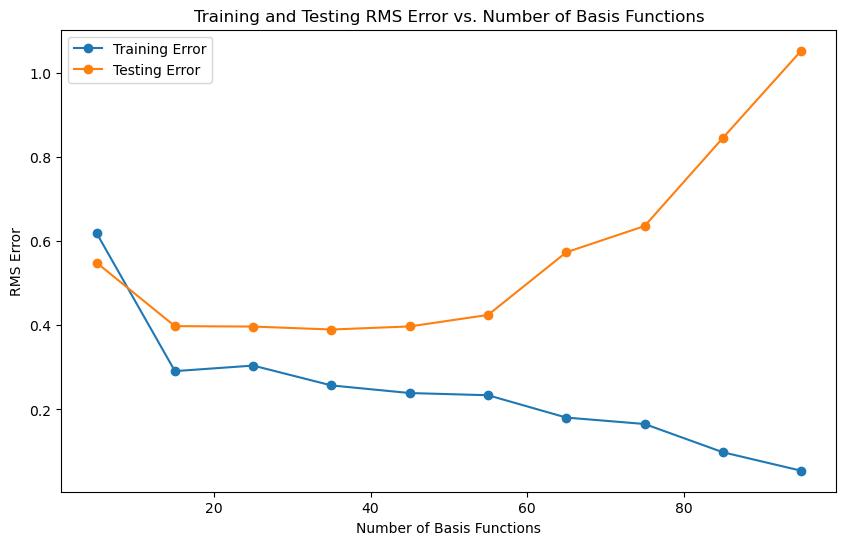

In [244]:
# Plot training and testing errors for varying number of basis functions
plt.figure(figsize=(10, 6))
plt.plot(basis_sizes, train_errors, label='Training Error', marker='o')
plt.plot(basis_sizes, test_errors, label='Testing Error', marker='o')
plt.xlabel('Number of Basis Functions')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Number of Basis Functions')
plt.legend()
plt.show()

# part 4-b

In [245]:
# Part 2: L2-regularized regression with fixed number of basis functions and varying regularization
M = 90  # Fixed number of basis functions
random_indices = np.random.permutation(X_train.shape[0])[:M]
centers = X_train[random_indices]

# Compute Gaussian basis matrices for training and testing data
Phi_train = gaussian_basis(X_train, centers, s)
Phi_test = gaussian_basis(X_test, centers, s)

In [246]:
# Regularization parameters to try
lambdas = [0, 0.01, 0.1, 1, 10, 100, 1000]
train_errors = []
test_errors = []

for lambda_value in lambdas:
    # Regularized solution: (Phi^T * Phi + λI)θ = Phi^T * y
    I = np.eye(Phi_train.shape[1])
    theta = np.linalg.solve(Phi_train.T @ Phi_train + lambda_value * I, Phi_train.T @ y_train)

    # Make predictions
    y_train_pred = Phi_train @ theta
    y_test_pred = Phi_test @ theta

    # Calculate RMSE for both training and testing data
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)

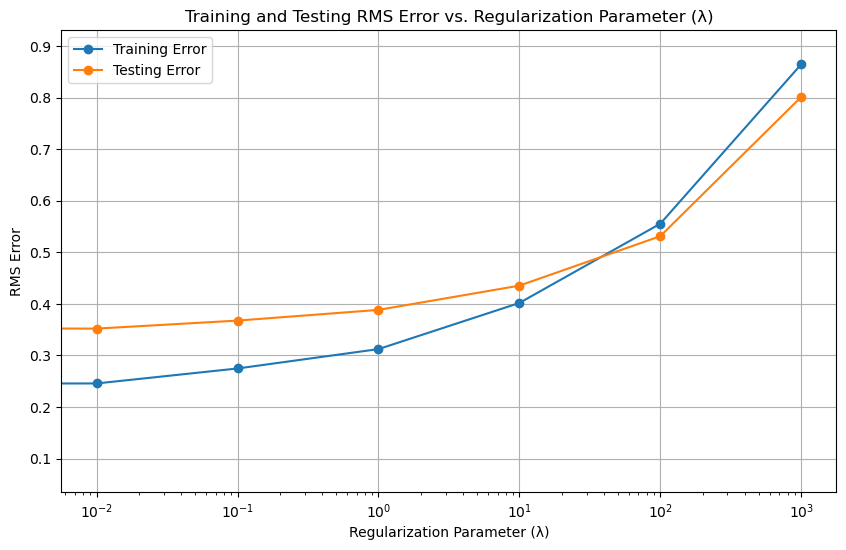

In [247]:
# Plot training and testing errors for varying regularization values
plt.figure(figsize=(10, 6))
plt.semilogx(lambdas, train_errors, label='Training Error', marker='o')
plt.semilogx(lambdas, test_errors, label='Testing Error', marker='o')
plt.xlabel('Regularization Parameter (λ)')
plt.ylabel('RMS Error')
plt.title('Training and Testing RMS Error vs. Regularization Parameter (λ)')
plt.legend()
plt.grid(True)
plt.show()